In [85]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [156]:
import os
import json
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import statsmodels.api as sm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from bprime.plots import surface_plot
from bprime.learn import LearnedFunction

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
lowess = sm.nonparametric.lowess

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [4]:

def log_tick_formatter(val, pos=None):
    return f"$10^{{{np.round(val, 1)}}}$"


@np.vectorize
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))

@np.vectorize
def bgs_segment(mu, s, rf, rbp, L):
    r = rbp*L
    a = -s*mu*L
    b = (1-s)**2 # rf^2 terms
    c = 2*s*(1-s)+r*(1-s)**2 # rf terms
    d = s**2 + r*s*(1-s) # constant terms
    return np.exp(a / (b*rf**2 + c*rf + d))

In [5]:
bgs_rec(1e-8, 1e-3, 1e-8, 1e3)

array(0.99005003)

## Data

In [135]:
with open('../slim_sims/classic_bgs.json') as f:
    sim_params = json.load(f)
sim_params

{'name': 'classicbgs',
 'params': {'N': {'lower': 1000, 'upper': 1000, 'log10': False, 'type': 'int'},
  'mu': {'lower': 5.5e-09, 'upper': 1e-05, 'log10': False, 'type': 'float'},
  's': {'lower': -4, 'upper': -1, 'log10': True, 'type': 'float'},
  'h': {'lower': 0.5, 'upper': 0.5, 'log10': False, 'type': 'float'},
  'rbp': {'lower': 1.1e-08, 'upper': 1.1e-08, 'log10': False, 'type': 'float'},
  'recfrac': {'lower': -8, 'upper': -6, 'log10': True, 'type': 'float'},
  'seglen': {'lower': 1000, 'upper': 1000, 'log10': False, 'type': 'int'}},
 'init_runtime': 0.25,
 'nsamples': 100000}

In [6]:
sim_data = np.load('../data/slim_sims/B_data.npz', allow_pickle=True)

In [7]:
# for extracting columns (more safely than remembering indices
def index_cols(cols):
    index = {c: i for i, c in enumerate(cols)}
    def get(*args):
        return tuple(index[c] for c in args)
    return get

Xcols = index_cols(sim_data['features'])
ycols = index_cols(sim_data['targets'])
sim_data['features'], sim_data['targets']

(array(['N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'], dtype='<U7'),
 array(['pi', 'Bhat', 'Ef', 'Vf', 'load'], dtype='<U4'))

In [8]:
assert(len(sim_data['features']) == sim_data['X'].shape[1])

In [9]:
Xo, yo = np.array(sim_data['X']), sim_data['y']

In [11]:
# how strong is selection?
(Xo[:, 1] > 1e-3).mean()

0.669124136856861

To be aligned with classic BGS theory, let's parameterize the heterozygous effect as $sh$. We build up our training dataset:

In [131]:
X = np.hstack((Xo[:, Xcols('mu')], np.prod(Xo[:, Xcols('s', 'h')], axis=1)[:, None], Xo[:, Xcols('recfrac')]))
X

array([[5.3880e-06, 3.6275e-03, 1.9010e-08],
       [6.3350e-06, 6.1650e-04, 3.3870e-08],
       [6.4200e-06, 2.8550e-03, 1.4250e-07],
       ...,
       [5.2750e-07, 8.6100e-03, 1.1690e-07],
       [6.7120e-06, 2.1320e-04, 4.1970e-08],
       [3.2460e-06, 9.6400e-05, 5.0280e-07]])

Now extract the target, $\hat{B}$.

In [132]:
y = yo[:, ycols('Bhat')]

Use the `LearnedFunction` class to store data, etc.

In [195]:
X

array([[5.3880e-06, 3.6275e-03, 1.9010e-08],
       [6.3350e-06, 6.1650e-04, 3.3870e-08],
       [6.4200e-06, 2.8550e-03, 1.4250e-07],
       ...,
       [5.2750e-07, 8.6100e-03, 1.1690e-07],
       [6.7120e-06, 2.1320e-04, 4.1970e-08],
       [3.2460e-06, 9.6400e-05, 5.0280e-07]])

In [196]:
domain = {p: sim_params['params'][p] for p in ('mu', 's', 'recfrac')}
func = LearnedFunction(X, y, domain=domain)
func

LearnedFunction with 3 feature(s) and 1 target(s)
 feature(s):
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - s ∈ [-4, -1] (log10, None)
  - recfrac ∈ [-8, -6] (log10, None)
Features normalized? False
Features split? False

In [197]:
func.split(random_state=6)

LearnedFunction with 3 feature(s) and 1 target(s)
 feature(s):
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - s ∈ [-4, -1] (log10, None)
  - recfrac ∈ [-8, -6] (log10, None)
Features normalized? False
Features split? True, test size: 10.0%

In [198]:
func.bounds

{'mu': (5.5e-09, 1e-05), 's': (-4, -1), 'recfrac': (-8, -6)}

In [199]:
feature_transforms = {'mu': None, 's': np.log10, 'recfrac': np.log10}
func.scale_features(transforms = feature_transforms)

LearnedFunction with 3 feature(s) and 1 target(s)
 feature(s):
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - s ∈ [-4, -1] (log10, <ufunc 'log10'>)
  - recfrac ∈ [-8, -6] (log10, <ufunc 'log10'>)
Features normalized? True
Features split? True, test size: 10.0%

In [200]:
func.X_test

array([[-1.13374456,  1.14632274, -0.16188436],
       [ 0.99842058, -0.58284083, -1.45997074],
       [-0.4923928 ,  1.41906824, -0.82164289],
       ...,
       [ 0.47457677, -1.15459934, -1.57221963],
       [ 1.02971943,  1.04229689, -0.69293357],
       [ 1.62329927, -0.36026254,  1.60300314]])

In [201]:
def network(n64=2, n32=6, output_activation='sigmoid'):
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(3,)))
    #model.add(layers.BatchNormalization(axis=1))
    for i in range(n64):
        model.add(layers.Dense(64, activation='elu'))
        #model.add(layers.Dropout(0.2))
    for i in range(n32):
        model.add(layers.Dense(32, activation='elu'))
        #model.add(layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation=output_activation))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [202]:
model = network(output_activation='sigmoid')
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                   patience=50, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(func.X_train, func.y_train, 
                    validation_split=0.2, 
                    #validation_data=(X_test_normalized, y_test),
                    batch_size=64, epochs=500, verbose=0, callbacks=[es, tqdm_callback])

func.model = model

Training:   0%|                                                                                               …

Restoring model weights from the end of the best epoch: 39.
Epoch 00089: early stopping


In [203]:
predict = func.predict_test()

In [211]:
idx = np.abs(predict - 1) < 0.1
((predict[idx] - func.y_test[idx])**2).mean()

0.18900921329881282

In [205]:
predict.max()

0.9988116

In [206]:
y_test.shape, predict.shape

((5779, 1), (5779,))

In [207]:
func.features

{'mu': 0, 's': 1, 'recfrac': 2}

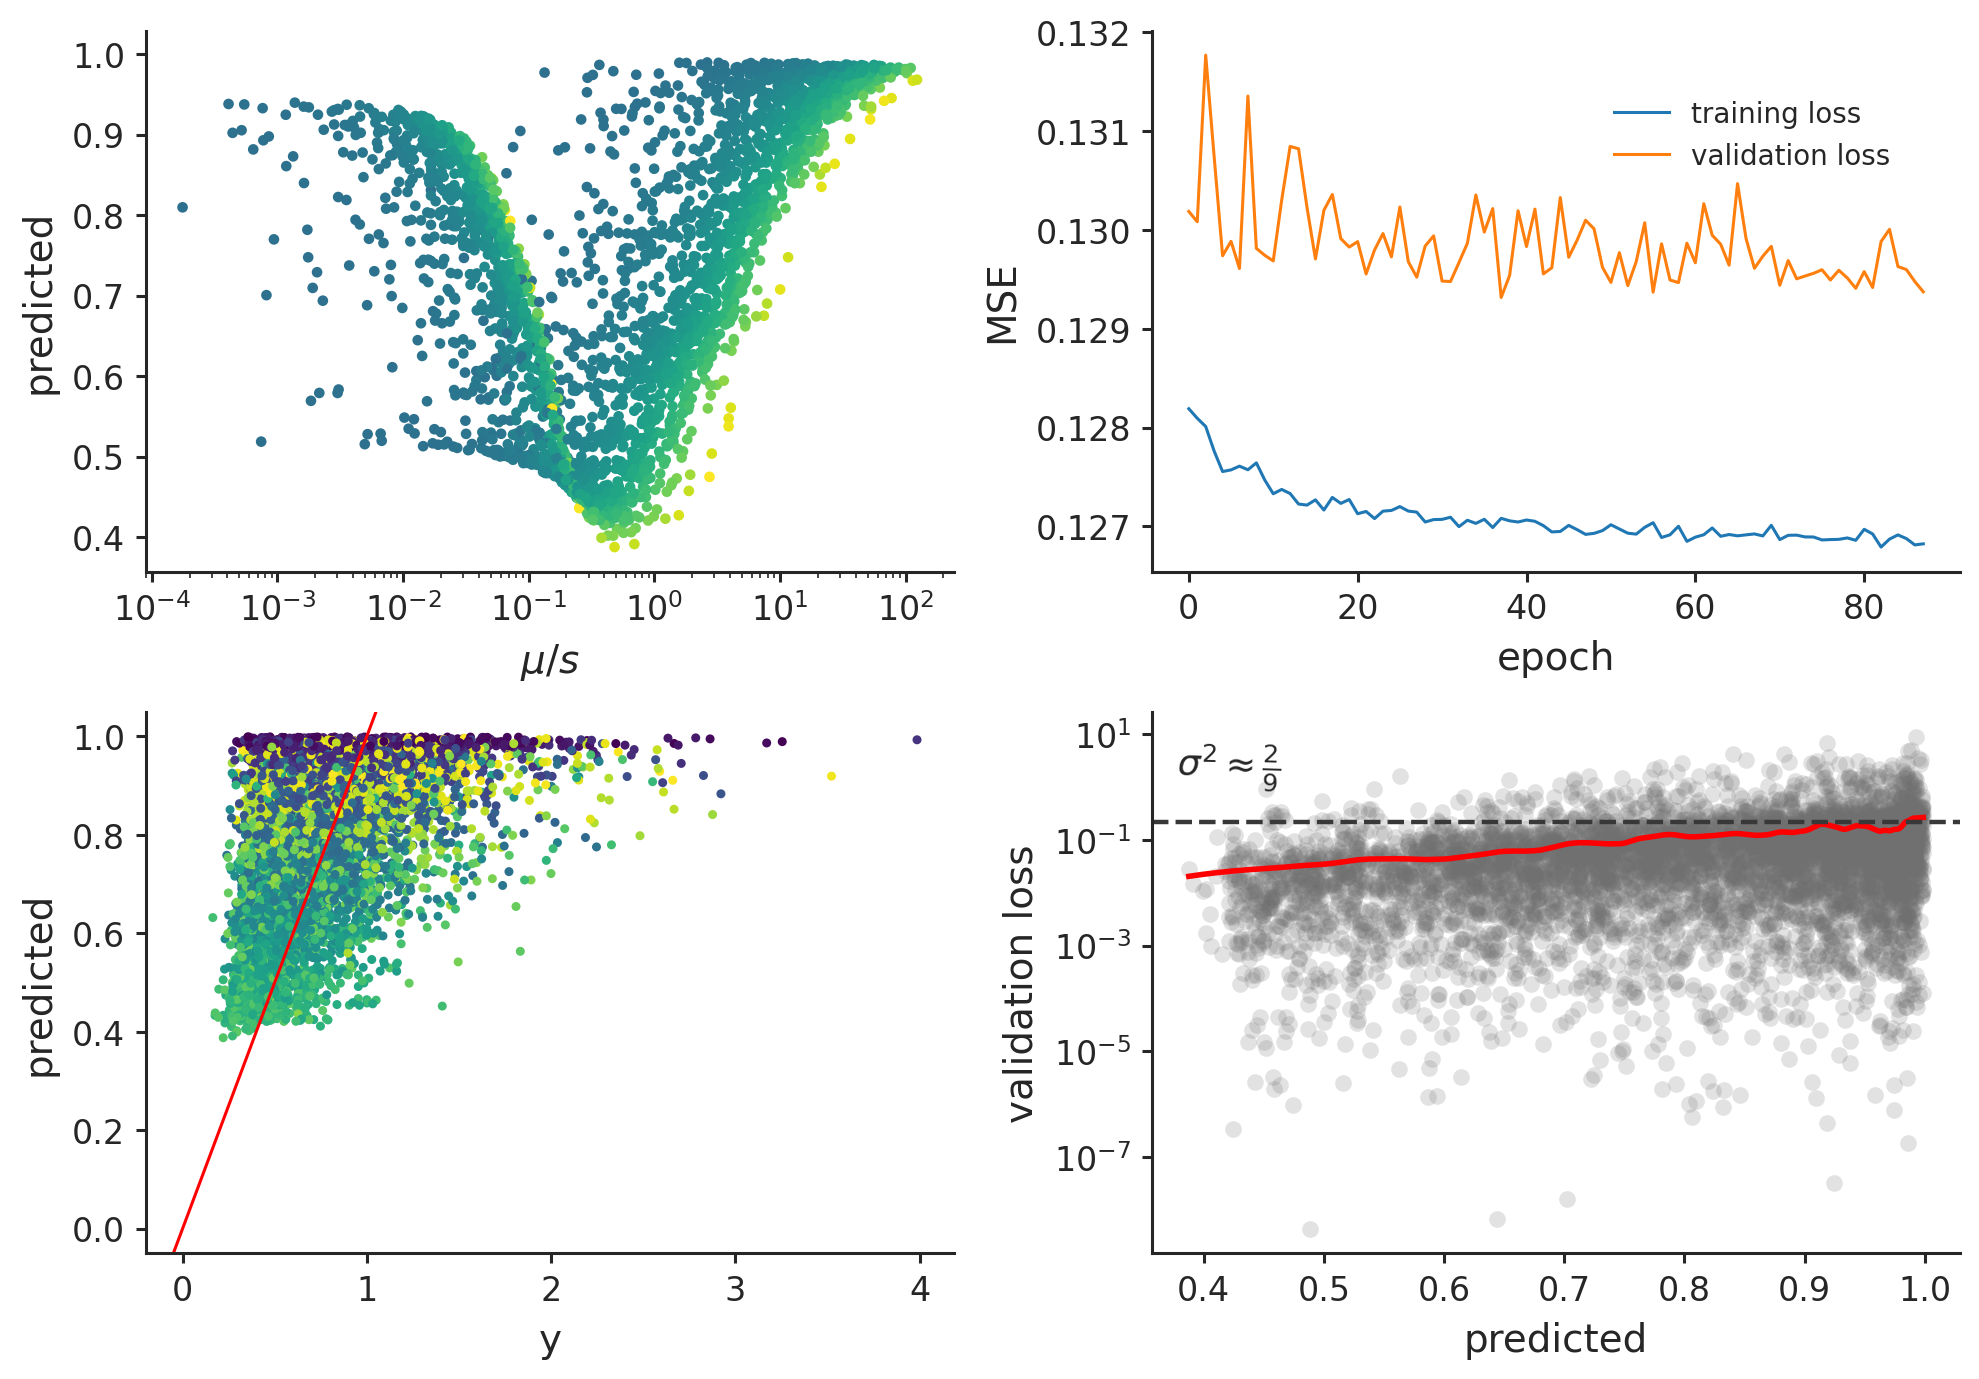

In [212]:
y_theory = bgs_rec(func.X_test_orig[:, 0], func.X_test_orig[:, 1], func.X_test_orig[:, 2], 1000)

mu_test, s_test, recrac_test = func.X_test.T
rate = mu_test/10**s_test

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

norm = plt.Normalize(np.min(mu_test), np.max(mu_test))

ax1.scatter(rate, predict, c=mu_test, cmap='viridis', s=8)
ax1.set_xlabel("$\mu/s$")
ax1.set_ylabel("predicted")
ax1.semilogx()
#cax1 = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#fig.colorbar(cmap=cm.viridis, cax=cax1, orientation='horizontal')

#n = 10
#yedges = np.linspace(y_test.min(), y_test.max(), n)
#xedges = np.linspace(predict.min(), predict.max(), n)
#H, xedges, yedges = np.histogram2d(y_test.squeeze(), predict, bins=(xedges, yedges))
#X, Y = np.meshgrid(xedges, yedges)
#ax3.pcolormesh(X, Y, H)
ax3.scatter(func.y_test, predict, c=func.X_test[:, 1], s=5)
ax3.axline((0, 0), slope=1, c='r')
ax3.set_xlabel('y')
ax3.set_ylabel('predicted')

ly = (predict - func.y_test.squeeze())**2
lX = predict
ax4.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax4.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

# the lowess fit was sensitive to it=0; this shows that the it=0 
# case is nearly identical to OLS, e.g. right thing to do
#mod = sm.OLS(ly, sm.add_constant(lX))
#res = mod.fit()
#lX_new = sm.add_constant(np.linspace(0.4, 1, 100))
#ax4.plot(lX_new, res.predict(lX_new), c='g')

xnew = np.linspace(0.4, 1, 100)
def B_var_limit(B, N, mu=1):
    return (3*mu + 8*B*N*mu**2)/(36*B*N)
ax4.axhline(B_var_limit(1, 1000), c='0.22', linewidth=1.6, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
#ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.text(0.03, 0.88, "$\sigma^2 \\approx \\frac{2}{9}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.semilogy()
ax4.set_ylabel('validation loss')
ax4.set_xlabel('predicted')

ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

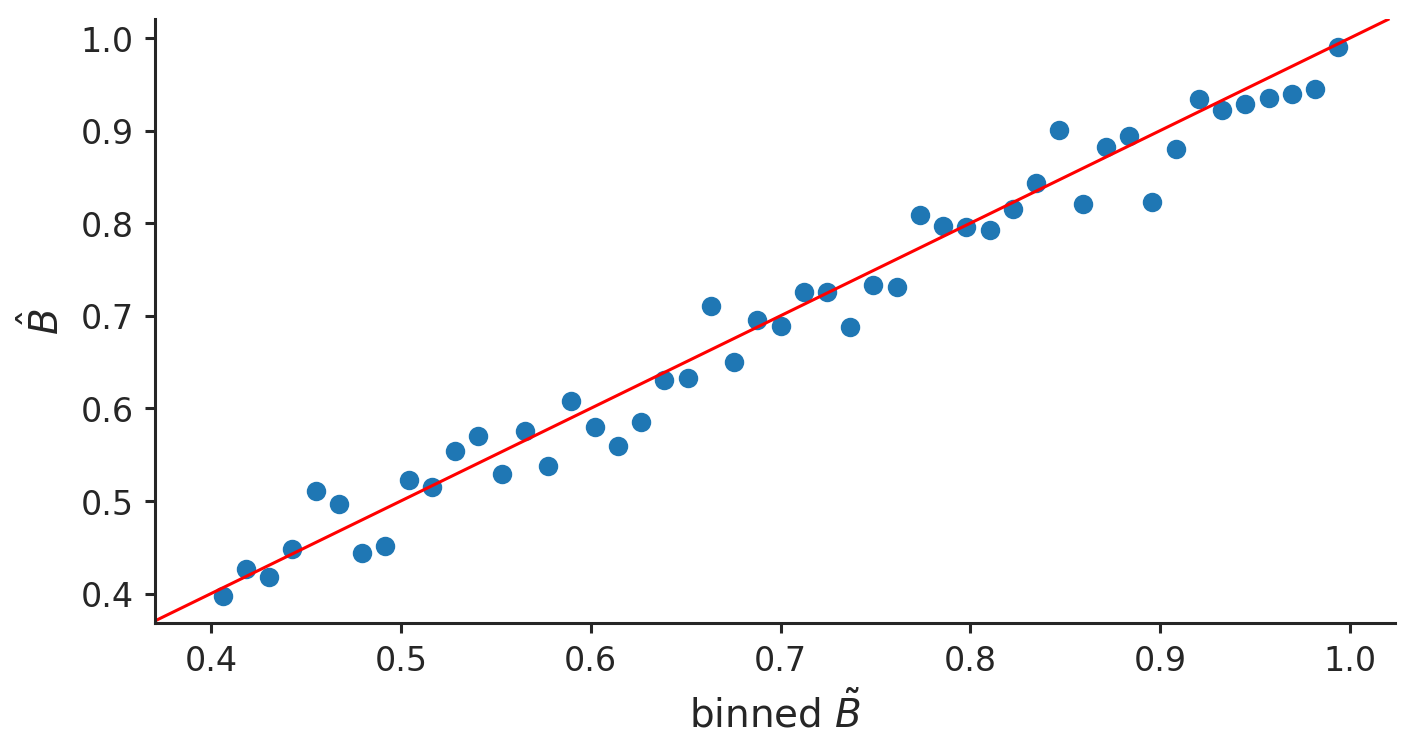

In [214]:
bins = np.linspace(0.4, 1, 50)
ytest_bins = stats.binned_statistic(predict, func.y_test.squeeze(), bins=bins)
fig, ax = plt.subplots()
ax.scatter(0.5*(bins[1:] + bins[:-1]), ytest_bins.statistic)
ax.set_ylabel('$\hat{B}$')
ax.set_xlabel('binned $\\tilde{B}$')
ax.axline((0.4, 0.4), slope=1, c='r')

In [267]:
(mu_grid, s_grid, _), X_mesh_orig, X_mesh, predict_grid = func.predict_grid({'mu': 101, 's': 100}, fix_X={'recfrac': np.log10(1e-8)})

In [268]:
mu_grid.shape

(101,)

In [269]:
X_mesh_orig

array([[ 5.500000e-09, -4.000000e+00, -8.000000e+00],
       [ 1.054450e-07, -4.000000e+00, -8.000000e+00],
       [ 2.053900e-07, -4.000000e+00, -8.000000e+00],
       ...,
       [ 9.800110e-06, -1.000000e+00, -8.000000e+00],
       [ 9.900055e-06, -1.000000e+00, -8.000000e+00],
       [ 1.000000e-05, -1.000000e+00, -8.000000e+00]])

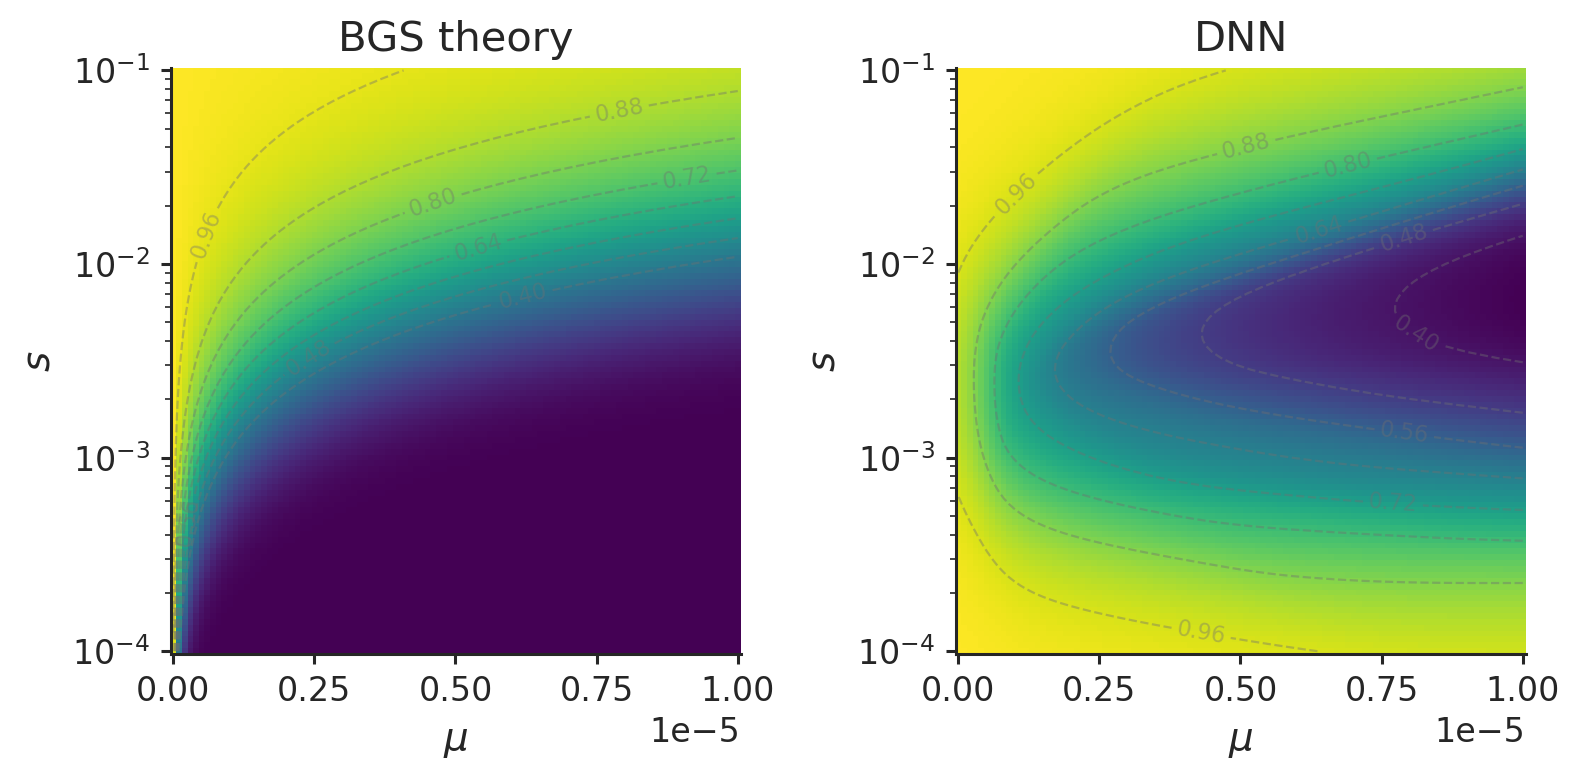

In [273]:
ncontour = np.linspace(0.4, 0.96, 8)

Z = bgs_segment(X_mesh_orig[:, 0], 10**X_mesh_orig[:, 1], 10**X_mesh_orig[:, 2], 1e-8, 1000).reshape(predict_grid.shape).squeeze()

Zp = predict_grid.squeeze()


fig, ax = plt.subplots(ncols=2)

surface_plot(mu_grid, s_grid, Z, scale='semilogy', xlabel="$\mu$", ylabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(mu_grid, s_grid, Zp, scale='semilogy', xlabel="$\mu$", ylabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))

ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

In [76]:
np.log10(mu_grid), np.log10(s_grid)

(array([-8.23328979, -7.87860224, -7.52391468, -7.16922713, -6.81453958,
        -6.45985202, -6.10516447, -5.75047691, -5.39578936, -5.04110181]),
 array([-4.30103   , -3.96770149, -3.63437298, -3.30104447, -2.96771597,
        -2.63438746, -2.30105895, -1.96773044, -1.63440193, -1.30107343]))

RuntimeError: Error in qhull Delaunay triangulation calculation: singular input data (exitcode=2); use python verbose option (-v) to see original qhull error.

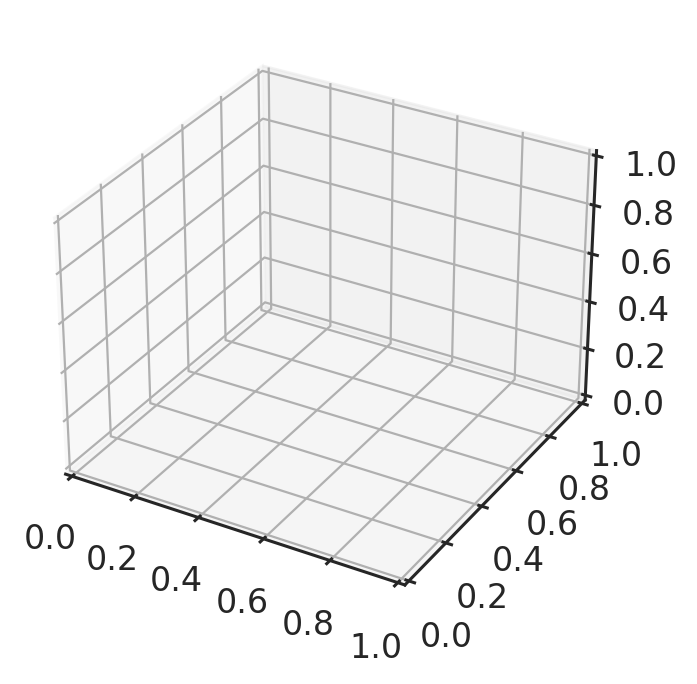

In [77]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_trisurf(np.log10(mu_grid), np.log10(s_grid), predict_grid, cmap='viridis')
#ax.plot_trisurf(np.log10(X2), np.log10(X1), theory_new, cmap='inferno_r')

#ax.scatter(X[:, 3], X[:, 1], y[:, 1], c=y[:, 1], cmap='viridis')
ax.view_init(30, 40)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_zlabel('B')
ax.set_ylabel('s')
ax.set_xlabel('$\mu$')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))


In [462]:
def surface_plot(x, y, z, xlabel=None, ylabel=None, 
                 scale=None, ncontour=None, contour_ndigits=2, 
                 figax=None, **kwargs):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    ax.pcolormesh(x, y, z, **kwargs)
    if scale is not None and scale != 'linear':
        avail_scales = ('loglog', 'semilogx', 'semilogy')
        if not scale in avail_scales:
            raise ValueError(f"scale must be one of {', '.join(avail_scales)}")
        getattr(ax, scale)()
    if ncontour is not None:
        cs = ax.contour(x, y, z, ncontour, colors='0.44', linestyles='dashed', linewidths=0.8, alpha=0.4)
        ax.clabel(cs, inline=True, fontsize=8)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)    
    return fig, ax 

In [483]:
new_X_grids

ncontour = np.linspace(0.4, 0.96, 8)

Z = bgs_segment(X2, X1, 2e-8, 1e-8, 1000)

Zp = model.predict(X_test_scaler.transform(Xnew)).reshape(X1.shape)


fig, ax = plt.subplots(ncols=2)

surface_plot(sn, mun, Z, scale='loglog', xlabel="s", ylabel="$\mu$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(sn, mun, Zp, scale='loglog', xlabel="s", ylabel="$\mu$", ncontour=ncontour, figax=(fig, ax[1]))

ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

ValueError: X has 2 features, but StandardScaler is expecting 3 features as input.

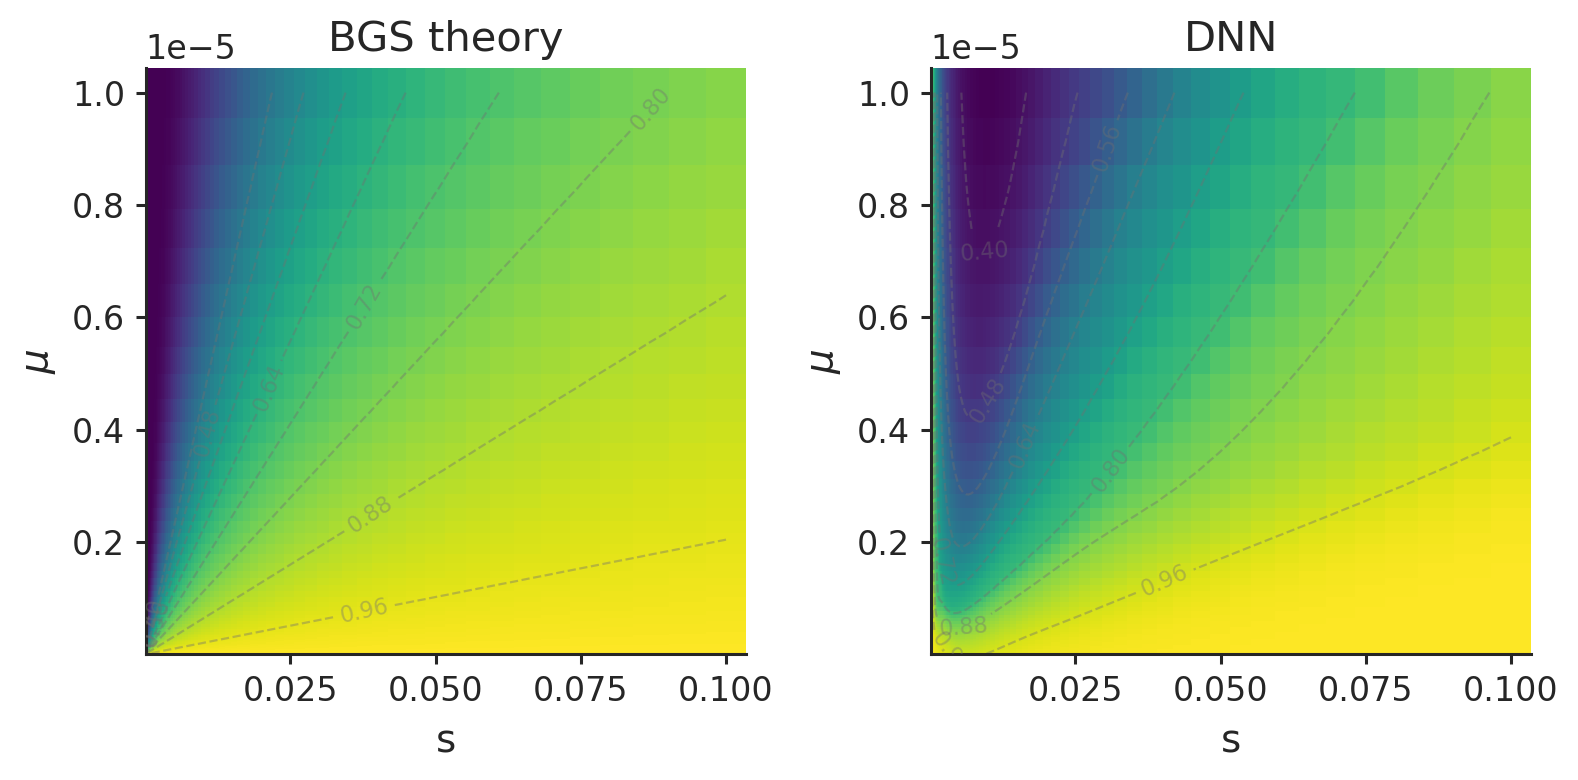

In [374]:
fig, ax = plt.subplots(ncols=2)

surface_plot(sn, mun, Z, xlabel="s", ylabel="$\mu$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(sn, mun, Zp, xlabel="s", ylabel="$\mu$", ncontour=ncontour, figax=(fig, ax[1]))

ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()


In [29]:
Zdiff = np.abs(Zp - Z)
figax = plt.subplots(figsize=(3, 3))
surface_plot(sn, mun, Zdiff, scale='loglog', xlabel="s", ylabel="$\mu$", ncontour=ncontour, 
                      cmap='inferno_r', figax=figax)

NameError: name 'Zp' is not defined

In [30]:
model.evaluate(X_test_normalized, y_test)

181/181 [==============================] - 0s 3ms/step - loss: 0.1193 - mean_absolute_error: 0.2508


[0.11927732080221176, 0.250848650932312]

In [55]:
model.evaluate(X_test_normalized, y_test)

3125/3125 [==============================] - 5s 2ms/step - loss: 0.1446 - mean_absolute_error: 0.2683


[0.1446310430765152, 0.2682616710662842]

In [284]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(0.26052667821272607, 0.40324143167388765)

In [171]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(5.392334013709564e-06, 0.9286115050067685)

(array([  86., 1026., 3738., 6127., 5709., 3269., 1272.,  295.,   27.,
           8.]),
 array([-0.62505611, -0.48181238, -0.33856864, -0.1953249 , -0.05208117,
         0.09116257,  0.23440631,  0.37765004,  0.52089378,  0.66413752,
         0.80738125]),
 <BarContainer object of 10 artists>)

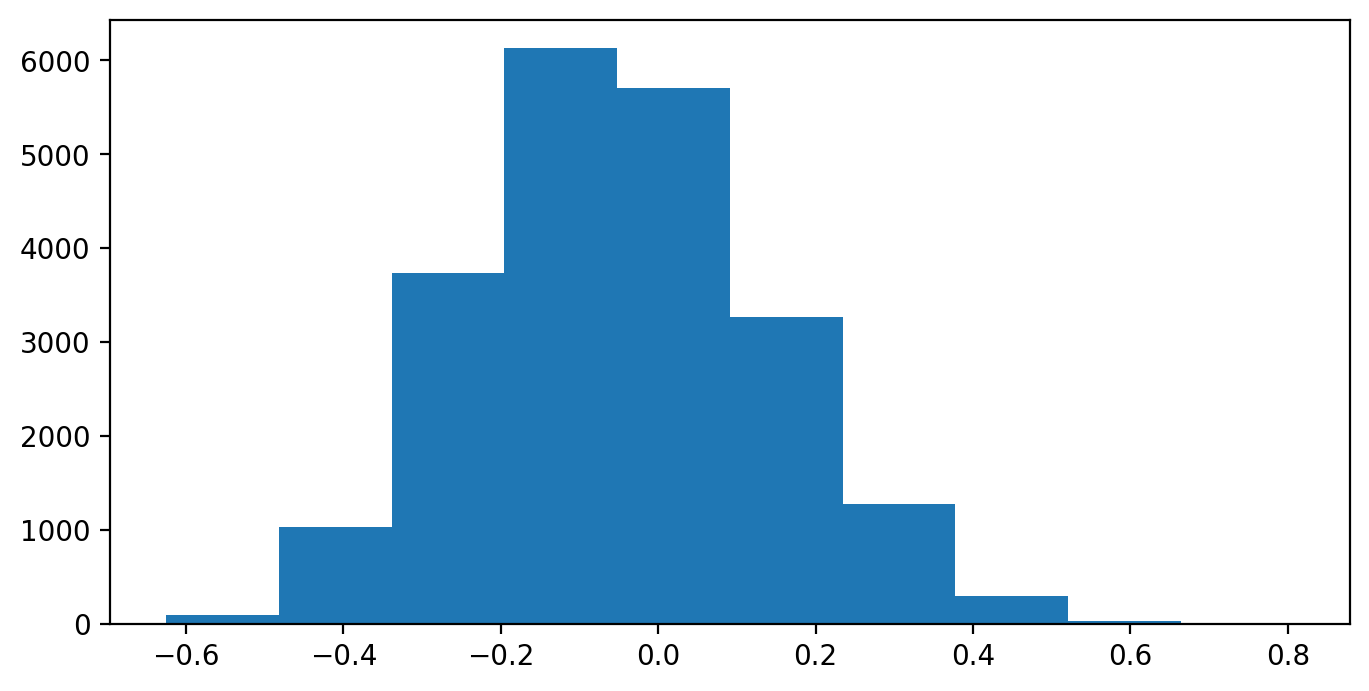

In [202]:
fig, ax = plt.subplots()
ax.hist(np.log10(y[:, 1].flatten()))

Text(0, 0.5, 'B')

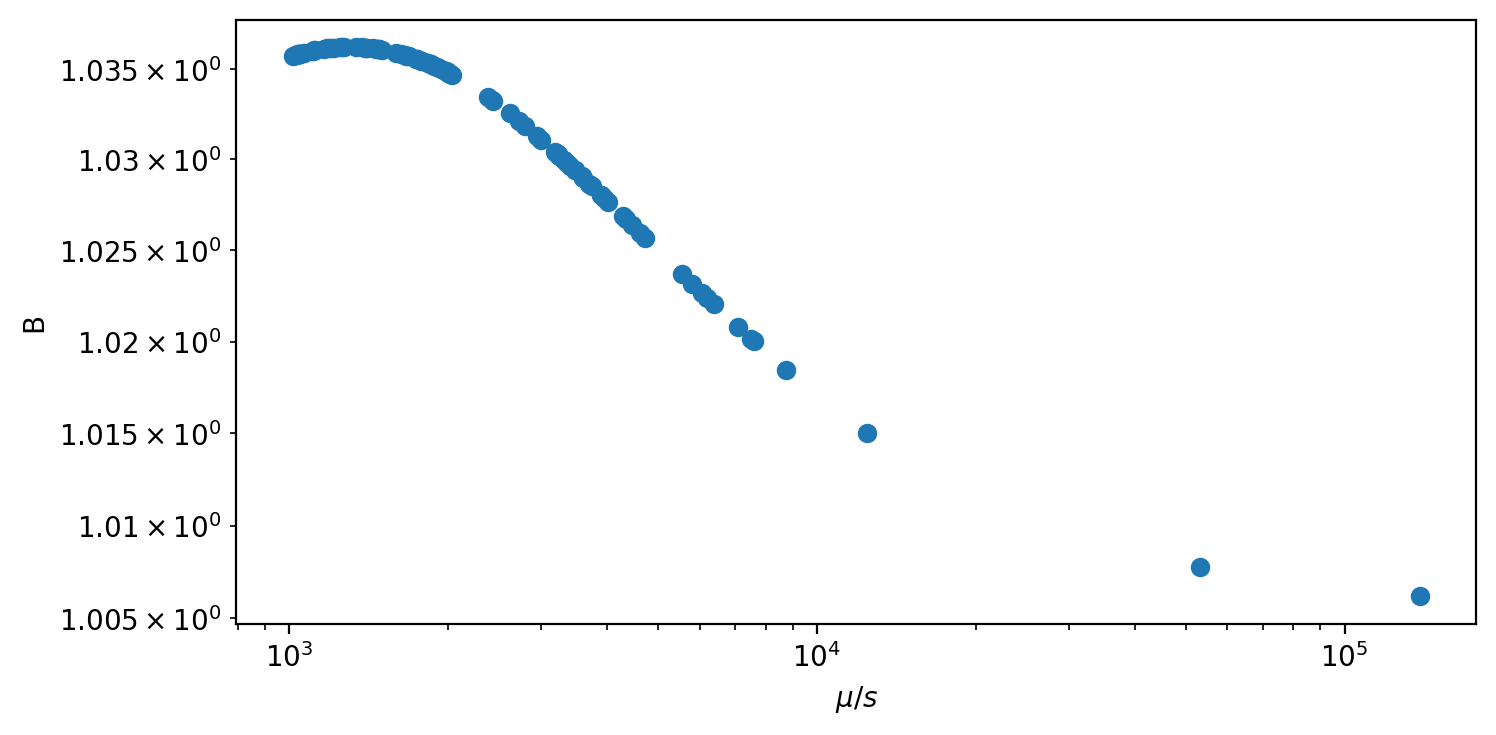

In [245]:
n = 100
mu = np.random.uniform(1e-8, 1e-8, n)
s = np.random.uniform(1e-6, 1e-1, n)
#rbp = np.random.uniform(1e-7, 1e-9, n)
rbp = np.repeat(1e-8, n)
#recfrac = np.random.uniform(1e-7, 1e-3, n)
recfrac = np.repeat(1e-8, n)
#L = np.random.uniform(10, 100_000, n)
L = np.repeat(1000, n)
#N = np.random.uniform(50, 10_000, n)
N = np.repeat(100, n)
#xnew = np.array((mu, s, rbp, N, L)).T
#'N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'
xnew = np.array((N, s, mu, recfrac, rbp, L)).T
rate = xnew[:, 0]/xnew[:, 1]
fig, ax = plt.subplots()
ax.scatter(rate, model.predict(X_scaler.transform(xnew)))
#ax.scatter(rate, bgs_rec(mu, s, rbp, L))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mu/s$')
ax.set_ylabel('B')

In [105]:
tf.reduce_mean(np.abs(predict.flatten() - y_theory.flatten()))

<tf.Tensor: shape=(), dtype=float64, numpy=0.007151165998975198>

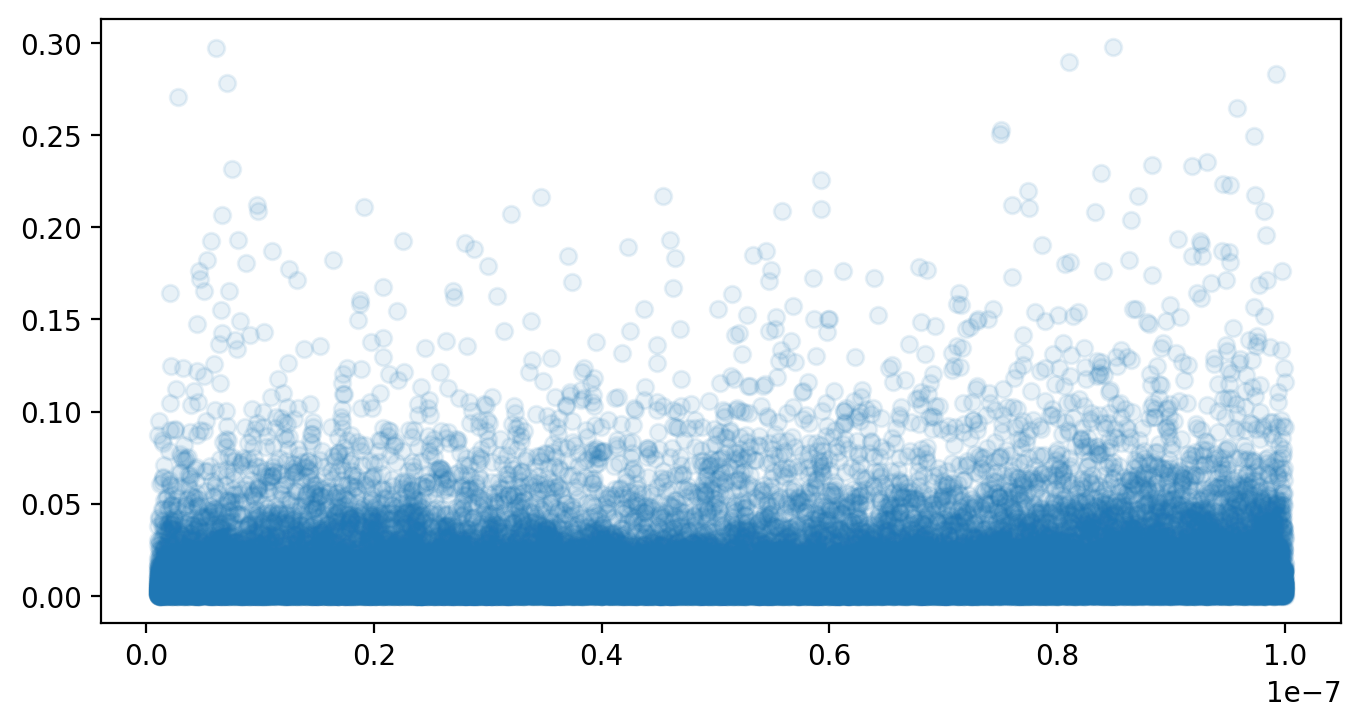

In [ ]:
plt.scatter(X_test[:, 3], np.abs(predict.flatten() - y_theory.flatten()), alpha=0.1)

In [212]:
dat = np.load('/home/vsb/projects/bprime/data/slim_sims/B_data.npz')

In [213]:
X, y, features = dat['X'], dat['y'], dat['features']

In [214]:
X, features

(array([[1.000e+03, 3.560e-02, 5.000e-01, ..., 1.714e-08, 1.100e-08,
         1.000e+03],
        [1.000e+03, 5.710e-03, 5.000e-01, ..., 1.425e-07, 1.100e-08,
         1.000e+03],
        [1.000e+03, 3.101e-03, 5.000e-01, ..., 7.648e-08, 1.100e-08,
         1.000e+03],
        ...,
        [1.000e+03, 4.264e-04, 5.000e-01, ..., 4.197e-08, 1.100e-08,
         1.000e+03],
        [1.000e+03, 1.066e-02, 5.000e-01, ..., 8.634e-08, 1.100e-08,
         1.000e+03],
        [1.000e+03, 1.393e-02, 5.000e-01, ..., 3.009e-08, 1.100e-08,
         1.000e+03]]),
 array(['N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'], dtype='<U7'))

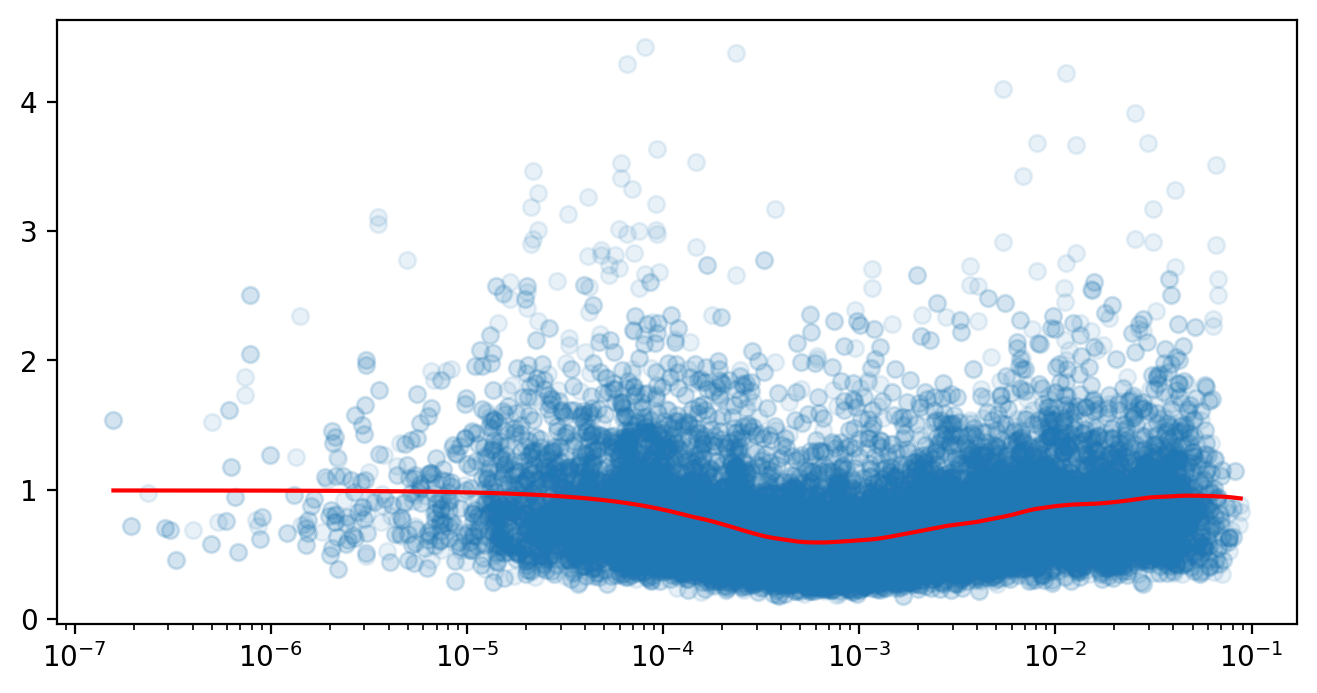

In [215]:
idx = X[:, 4] < 1
rate = X[idx, 3]/X[idx, 1]
yy = y[idx, 1]
fig, ax = plt.subplots()
ax.scatter(rate, yy, alpha=0.1)

z = lowess(yy, rate, frac= 1./3, it=0)
ax.plot(z[:, 0], z[:, 1], c='r')
ax.set_xscale('log')

- make a kernel ridge vs DNN predicted surface plot
- weak impact on B can be caused by both BGS and weak selection
- is the mulitplicative right?


In [216]:
X.shape, y.shape


((19517, 7), (19517, 5))

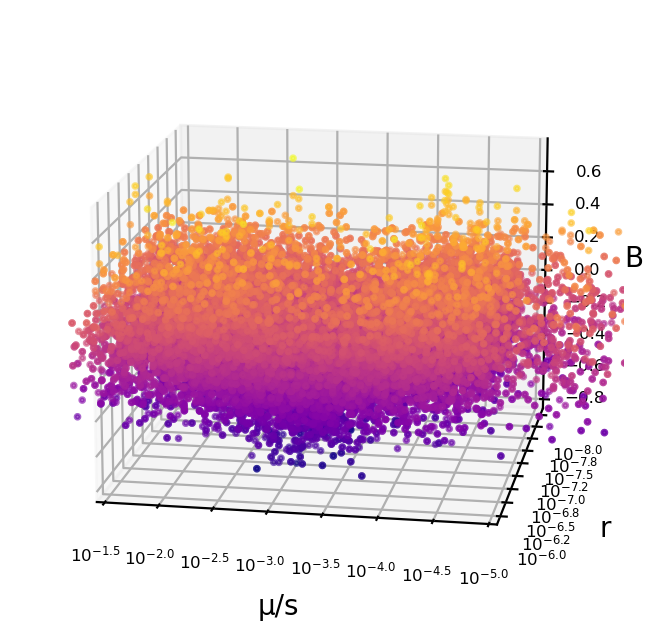

In [479]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(np.log10(X[:, 3]/X[:, 1]), np.log10(X[:, 4]), np.log10(y[:, 1]), s=3, c=np.log10(y[:, 1]), alpha=0.6, cmap='plasma')
#ax.scatter(X[:, 3], X[:, 1], y[:, 1], c=y[:, 1], cmap='viridis')

#ax.view_init(5, 270)
ax.view_init(15, 100)
ax.set_xlim(-5, -1.5)
ax.set_xlabel('μ/s')
ax.set_ylabel('r')
ax.set_zlabel('B')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))


In [218]:
from sklearn.kernel_ridge import KernelRidge

In [234]:
krr = KernelRidge(gamma=0.1, kernel='rbf')
features = np.stack((X[:, 3]/X[:, 1], X[:, 4])).T
krrm = krr.fit(features, y[:, 1])

Text(0.5, 0, 'B')

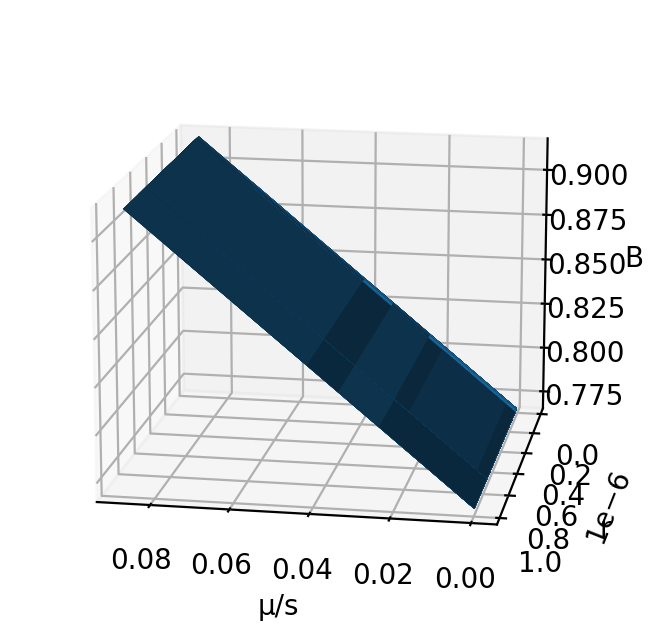

In [235]:
n = 100
xnew = 10**np.random.uniform(-5, -1, n)
ynew = 10**np.random.uniform(-8, -6, n)
Xg, Yg = np.meshgrid(xnew, ynew)
ynew = krrm.predict(np.stack((Xg.flatten(), Yg.flatten())).T).reshape(Xg.shape)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.scatter(np.log10(X[:, 3]/X[:, 1]), np.log10(X[:, 4]), np.log10(y[:, 1]), s=3, c=y[:, 1], alpha=0.6, cmap='viridis')
#ax.scatter(X[:, 3], X[:, 1], y[:, 1], c=y[:, 1], cmap='viridis')
ax.plot_surface(Xg, Yg, ynew)
#ax.view_init(5, 270)
ax.view_init(15, 100)
#ax.set_xlim(-5, -1.5)
ax.set_xlabel('μ/s')
ax.set_ylabel('r')
ax.set_zlabel('B')
#ax.tick_params(axis='both', which='major', labelsize=6)
#ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
